# Twitter Financial News Classification

## 1. Data Loading and Overview

In [1]:
import pandas as pd

train_df = pd.read_csv("train_data.csv")
valid_df = pd.read_csv("valid_data.csv")

train_df.head()

,text,label
0,Here are Thursday's biggest analyst calls: App...,0
1,Buy Las Vegas Sands as travel to Singapore bui...,0
2,"Piper Sandler downgrades DocuSign to sell, cit...",0
3,"Analysts react to Tesla's latest earnings, bre...",0
4,Netflix and its peers are set for a ‘return to...,0


In [2]:
valid_df.head()

,text,label
0,Analyst call of the day for @CNBCPro subscribe...,0
1,"Loop upgrades CSX to buy, says it's a good pla...",0
2,BofA believes we're already in a recession — a...,0
3,JPMorgan sees these derivative plays as best w...,0
4,Morgan Stanley's Huberty sees Apple earnings m...,0


In [3]:
train_df.shape, valid_df.shape

((16990, 2), (4117, 2))

## 2. Exploratory Data Analysis (EDA)
### 2.1 Label Distribution

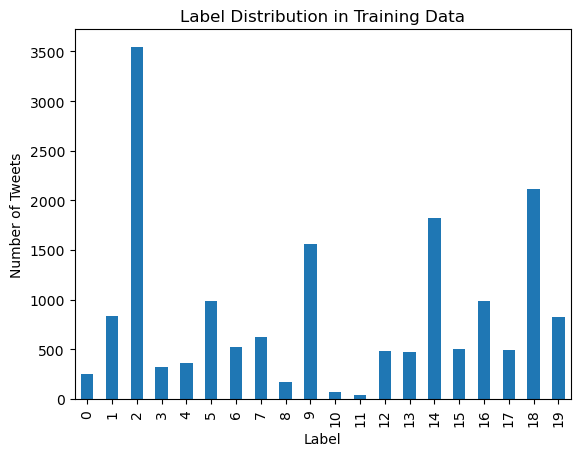

Highly imbalanced data


In [4]:
import matplotlib.pyplot as plt

# count labels
label_counts = train_df['label'].value_counts().sort_index()

# plot
plt.figure()
label_counts.plot(kind='bar')
plt.xlabel('Label')
plt.ylabel('Number of Tweets')
plt.title('Label Distribution in Training Data')
plt.show()
print("Highly imbalanced data")

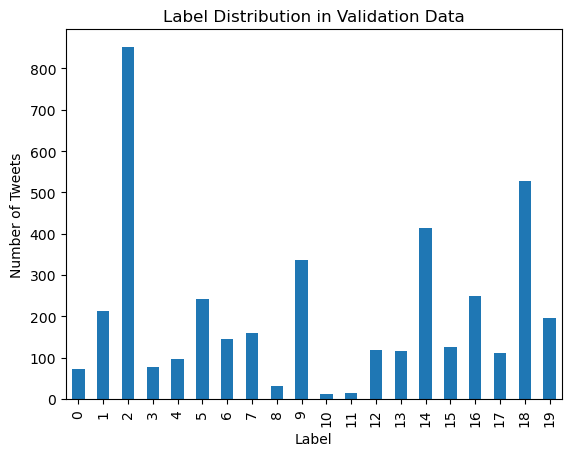

In [5]:
import matplotlib.pyplot as plt

# count labels in validation data
valid_label_counts = valid_df['label'].value_counts().sort_index()

# plot
plt.figure()
valid_label_counts.plot(kind='bar')
plt.xlabel('Label')
plt.ylabel('Number of Tweets')
plt.title('Label Distribution in Validation Data')
plt.show()

### 2.2 Tweet Length Analysis

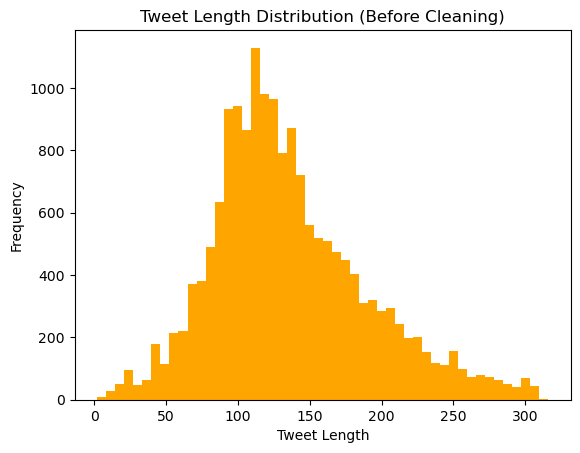

In [6]:
# calculate tweet lengths
tweet_lengths = train_df['text'].apply(len)

# plot
plt.figure()
plt.hist(tweet_lengths, bins=50, color='orange')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.title('Tweet Length Distribution (Before Cleaning)')
plt.show()

In [7]:
import re

def clean_text(text):
    text = re.sub(r'http\S+|www\S+', '', text)  # remove URLs
    text = re.sub(r'[^A-Za-z\s]', '', text)    # remove punctuation & numbers
    text = text.lower()
    return text

train_df['clean_text'] = train_df['text'].apply(clean_text)

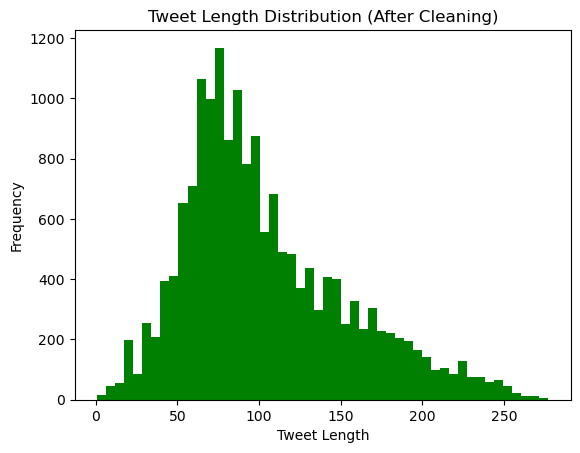

In [8]:
clean_tweet_lengths = train_df['clean_text'].apply(len)

plt.figure()
plt.hist(clean_tweet_lengths, bins=50, color='green')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.title('Tweet Length Distribution (After Cleaning)')
plt.show()

### 2.3 Word Cloud Analysis

In [12]:
!pip install wordcloud

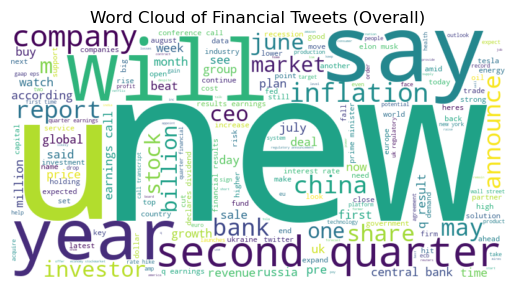

In [9]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# combine all cleaned text
all_text = " ".join(train_df['clean_text'])

# generate word cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=200
).generate(all_text)

# plot
plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Financial Tweets (Overall)')
plt.show()

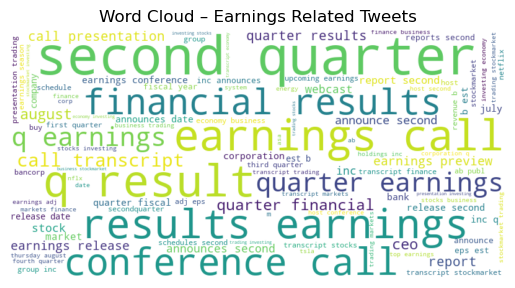

In [10]:
# filter earnings-related tweets (LABEL_5 = Earnings)
earnings_text = " ".join(
    train_df[train_df['label'] == 5]['clean_text']
)

# generate word cloud
earnings_wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=100
).generate(earnings_text)

# plot
plt.figure()
plt.imshow(earnings_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud – Earnings Related Tweets')
plt.show()

## 3. Text Preprocessing and Feature Preparation

In [11]:
# features and target
X_train = train_df['clean_text']
y_train = train_df['label']

X_valid = valid_df['text'].apply(clean_text)
y_valid = valid_df['label']

## 4. Baseline Model: TF-IDF + Logistic Regression

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [13]:
# TF-IDF vectorization
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2)
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_valid_tfidf = tfidf.transform(X_valid)

In [15]:
# Logistic Regression model
log_reg = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    n_jobs=-1
)

log_reg.fit(X_train_tfidf, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, n_jobs=-1)

In [16]:
# predictions on validation data
y_pred = log_reg.predict(X_valid_tfidf)

# evaluation report
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.86      0.73        73
           1       0.82      0.79      0.80       214
           2       0.86      0.74      0.80       852
           3       0.77      0.81      0.78        77
           4       0.96      0.98      0.97        97
           5       0.97      0.91      0.94       242
           6       0.69      0.86      0.77       146
           7       0.83      0.86      0.84       160
           8       0.61      0.78      0.68        32
           9       0.63      0.74      0.68       336
          10       0.33      0.69      0.45        13
          11       0.82      1.00      0.90        14
          12       0.74      0.80      0.77       119
          13       0.76      0.74      0.75       116
          14       0.79      0.71      0.75       415
          15       0.73      0.81      0.77       125
          16       0.88      0.88      0.88       249
          17       0.85    

### 4.1 Evaluation: Confusion Matrix

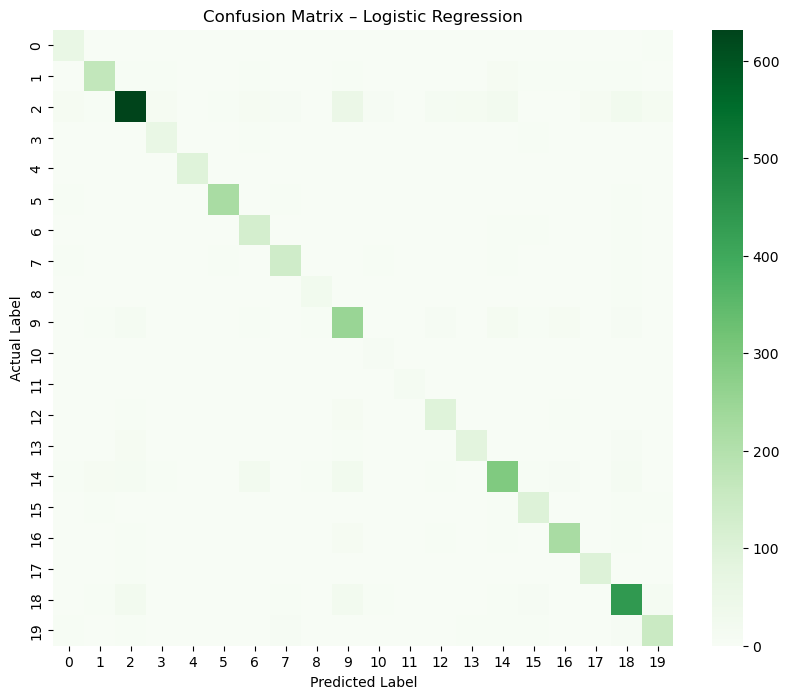

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# compute confusion matrix
cm = confusion_matrix(y_valid, y_pred)

# plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, cmap='Greens', cbar=True)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix – Logistic Regression')
plt.show()

## 5. Improved Model: TF-IDF + Linear SVM

In [18]:
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

In [19]:
# Linear SVM model
svm_model = LinearSVC(class_weight='balanced')

svm_model.fit(X_train_tfidf, y_train)

LinearSVC(class_weight='balanced')

In [20]:
# predictions on validation data
y_pred_svm = svm_model.predict(X_valid_tfidf)

# evaluation report
print(classification_report(y_valid, y_pred_svm))

              precision    recall  f1-score   support

           0       0.73      0.79      0.76        73
           1       0.84      0.86      0.85       214
           2       0.89      0.81      0.85       852
           3       0.74      0.79      0.77        77
           4       0.95      0.99      0.97        97
           5       0.94      0.94      0.94       242
           6       0.74      0.82      0.78       146
           7       0.85      0.88      0.87       160
           8       0.76      0.78      0.77        32
           9       0.75      0.75      0.75       336
          10       0.41      0.69      0.51        13
          11       0.88      1.00      0.93        14
          12       0.85      0.86      0.85       119
          13       0.79      0.77      0.78       116
          14       0.82      0.80      0.81       415
          15       0.74      0.82      0.78       125
          16       0.88      0.89      0.89       249
          17       0.85    

### 5.1 Evaluation: Confusion Matrix

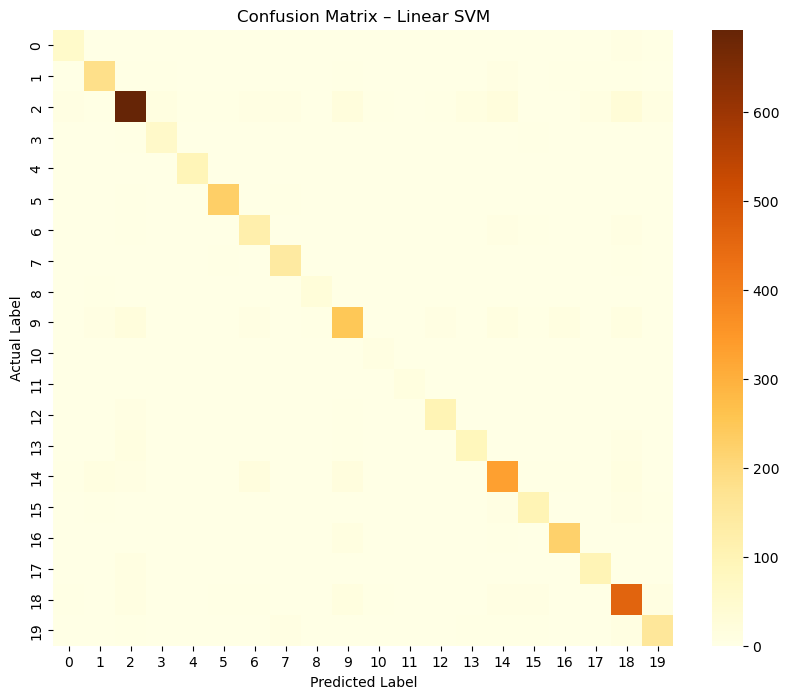

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# compute confusion matrix
cm_svm = confusion_matrix(y_valid, y_pred_svm)

# plot confusion matrix with warm colormap
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_svm,
    cmap='YlOrBr',   
    cbar=True
)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix – Linear SVM')
plt.show()

## 6. Neural Network Model: TF-IDF + ANN

In [22]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

In [25]:
# ANN model (simple, stable configuration)
ann_model = MLPClassifier(
    hidden_layer_sizes=(128,),
    activation='relu',
    solver='adam',
    max_iter=20,
    random_state=42
)

ann_model.fit(X_train_tfidf, y_train)

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(128,), max_iter=20, random_state=42)

In [26]:
# predictions on validation data
y_pred_ann = ann_model.predict(X_valid_tfidf)

# evaluation report
print(classification_report(y_valid, y_pred_ann))

              precision    recall  f1-score   support

           0       0.88      0.59      0.70        73
           1       0.89      0.84      0.86       214
           2       0.80      0.87      0.84       852
           3       0.90      0.71      0.80        77
           4       0.99      0.98      0.98        97
           5       0.96      0.91      0.93       242
           6       0.82      0.74      0.78       146
           7       0.89      0.83      0.86       160
           8       0.85      0.69      0.76        32
           9       0.71      0.76      0.73       336
          10       0.50      0.54      0.52        13
          11       1.00      0.57      0.73        14
          12       0.89      0.74      0.81       119
          13       0.81      0.69      0.74       116
          14       0.78      0.85      0.81       415
          15       0.81      0.74      0.78       125
          16       0.92      0.83      0.87       249
          17       0.98    

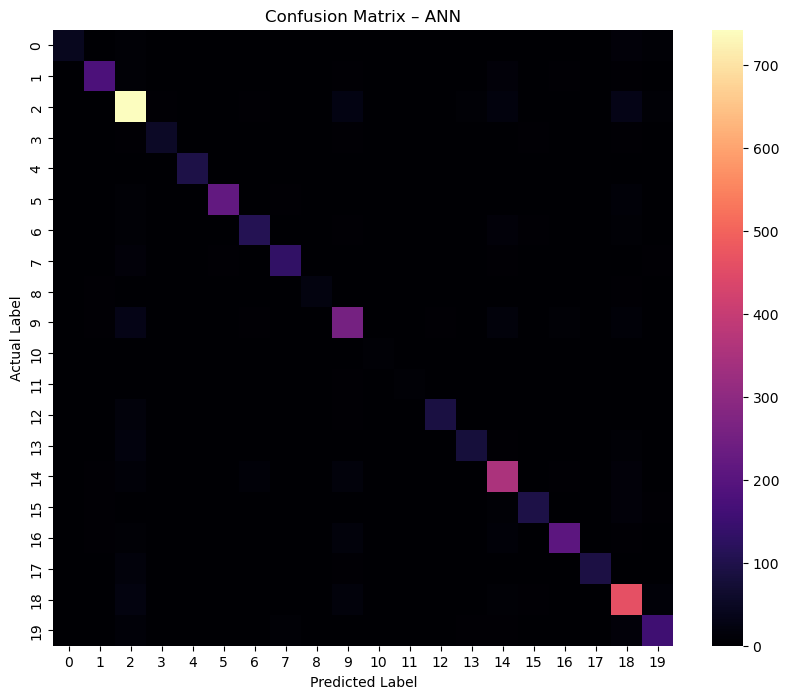

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# compute confusion matrix
cm_ann = confusion_matrix(y_valid, y_pred_ann)

# plot confusion matrix with warm palette
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_ann,
    cmap='magma',  
    cbar=True
)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix – ANN')
plt.show()

## 7. Model Comparison and Final Conclusion

### Model Comparison

Three models were evaluated for classifying financial news tweets into multiple categories:

- **Logistic Regression (TF-IDF)**  
  Provided a strong and stable baseline performance. It handled dominant classes well but showed limitations in minority categories due to class imbalance.

- **Linear SVM (TF-IDF)**  
  Produced results very similar to Logistic Regression, indicating that linear decision boundaries capture most of the structure in TF-IDF features for this dataset.

- **Artificial Neural Network (ANN)**  
  Showed comparable overall performance to linear models. While it did not significantly outperform them, it demonstrated the ability to model non-linear relationships in the data.

Overall, all three models exhibited similar confusion patterns, suggesting that feature representation plays a larger role than model complexity for this task.

---

### Final Conclusion

This project demonstrates an end-to-end financial news classification pipeline using Twitter data. Through exploratory data analysis, text preprocessing, feature extraction, and multiple models, the project highlights the challenges of multi-class and imbalanced financial text data.

Linear models with TF-IDF features proved to be effective and reliable baselines, while the neural network model provided an additional perspective without drastic performance gains.

---

### Finance Analyst Use Case

Such a classification system can help finance analysts:
- Quickly filter earnings-related or market-moving news
- Track macroeconomic or central bank discussions separately
- Reduce noise while monitoring large volumes of financial tweets
- Support faster thematic analysis for research and decision-making